# Visualize XAI
##### authors: Elizabeth A. Barnes and Noah Diffenbaugh
##### date: March 20, 2022


## Python stuff

In [1]:
import sys, imp, os, copy

import cmocean
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy as ct
import scipy.stats as stats
import tensorflow as tf
import tensorflow_probability as tfp
import silence_tensorflow
silence_tensorflow

import scipy.stats as stats
import seaborn as sns

import experiment_settings
import file_methods, plots, data_processing, xai

import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
savefig_dpi = 300
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [2]:
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"xarray version = {xr.__version__}")  
print(f"tensorflow version = {tf.__version__}")  
print(f"tensorflow-probability version = {tfp.__version__}")  

python version = 3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:27:43) 
[Clang 11.1.0 ]
numpy version = 1.22.2
xarray version = 2022.3.0
tensorflow version = 2.7.0
tensorflow-probability version = 0.15.0


## User Choices

In [3]:
EXP_NAME = 'exp3'#'exp15C_370'
PLOT_SEED = 1257

#-------------------------------------------------------

settings = experiment_settings.get_settings(EXP_NAME)
display(settings)

MODEL_DIRECTORY = 'saved_models/'        
PREDICTIONS_DIRECTORY = 'saved_predictions/'
DATA_DIRECTORY = 'data/'
DIAGNOSTICS_DIRECTORY = 'model_diagnostics/'
FIGURE_DIRECTORY = 'figures/'

{'save_model': True,
 'n_models': 20,
 'ssp': '370',
 'gcmsub': 'ALL',
 'obsdata': 'BEST',
 'target_temp': 1.5,
 'n_train_val_test': (7, 2, 1),
 'baseline_yr_bounds': (1850, 1899),
 'training_yr_bounds': (1970, 2100),
 'anomaly_yr_bounds': (1951, 1980),
 'anomalies': True,
 'remove_map_mean': False,
 'network_type': 'shash2',
 'hiddens': [10, 10],
 'dropout_rate': 0.0,
 'ridge_param': [10.0, 0.0],
 'learning_rate': 1e-05,
 'batch_size': 64,
 'rng_seed': 8889,
 'seed': None,
 'act_fun': ['relu', 'relu'],
 'n_epochs': 25000,
 'patience': 50,
 'exp_name': 'exp3'}

## Initial housekeeping

In [4]:
## determine how many GCMs are being used
filenames = file_methods.get_cmip_filenames(settings, verbose=0)
N_GCMS = len(filenames)

# load observations for diagnostics plotting
da_obs, x_obs, global_mean_obs = data_processing.get_observations(DATA_DIRECTORY, settings)
N_TRAIN, N_VAL, N_TEST, ALL_MEMBERS = data_processing.get_members(settings)

observations: filling NaNs with zeros
np.shape(x_obs) = (172, 10368)


## Plotting Functions

In [5]:
def set_cb_xai(cb):
    cb.set_label(None)
    cb.ax.set_xticks((-0.05,0.05))    
    cb.ax.set_xticklabels(['further\nfrom target','nearer\nto target'],
                          fontsize=FS*.8,
                         )    
    

In [6]:
FS = 10

### for white background...
plt.rc('text',usetex=False)
# plt.rc('text',usetex=True)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']}) 
plt.rc('savefig',facecolor='white')
plt.rc('axes',facecolor='white')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('xtick',color='dimgrey')
plt.rc('ytick',color='dimgrey')
################################  
################################  
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')  
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        ax.xaxis.set_ticks([]) 

def format_spines(ax):
    adjust_spines(ax, ['left', 'bottom'])
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('dimgrey')
    ax.spines['bottom'].set_color('dimgrey')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params('both',length=4,width=2,which='major',color='dimgrey')
#     ax.yaxis.grid(zorder=1,color='dimgrey',alpha=0.35)    
    

## Load the Model

In [7]:
rng = np.random.default_rng(settings["rng_seed"])
settings["seed"] = PLOT_SEED

# get the cmip data
(x_train, 
 x_val, 
 x_test, 
 y_train, 
 y_val, 
 y_test, 
 onehot_train, 
 onehot_val, 
 onehot_test, 
 y_yrs_train, 
 y_yrs_val, 
 y_yrs_test, 
 target_years, 
 map_shape,
 settings) = data_processing.get_cmip_data(DATA_DIRECTORY, settings)


# get model name
model_name = file_methods.get_model_name(settings)
model = file_methods.load_tf_model(model_name, MODEL_DIRECTORY)

[0 4 2 1 8 9 7] [6 5] [3]
tas_Amon_historical_ssp370_CanESM5_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2011
tas_Amon_historical_ssp370_ACCESS-ESM1-5_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2035
tas_Amon_historical_ssp370_UKESM1-0-LL_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2024
tas_Amon_historical_ssp370_MIROC-ES2L_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2038
tas_Amon_historical_ssp370_GISS-E2-1-G_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2029
tas_Amon_historical_ssp370_IPSL-CM6A-LR_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2020
tas_Amon_historical_ssp370_CESM2-LE2-smbb_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2030
---------------------------
data_train.shape = (49, 131, 72, 144)
data_val.shape = (14, 131, 72, 144)
data_test.shape = (7, 131, 72, 144)
(6419, 10368) (6419,) (6419,)
(1834, 10368) (1834,) (1834,)
(917, 10368) (917,) (917,)


## XAI for CMIP models

In [8]:
imp.reload(xai)
#=========================================
# Define the samples you want to explain
rng_subsample = np.random.default_rng(999)
top_pred_idx = 0
isubsample = rng_subsample.choice(np.arange(0,x_test.shape[0]),
                        size = 500,
                        replace = False,
                       )

inputs = np.copy(x_test[isubsample,:])
targets = np.copy(y_test[isubsample])
yrs = np.copy(y_yrs_test[isubsample])
preds = model.predict(inputs)

#=========================================
#---------------------------------------
# Gradient x Input
#---------------------------------------
# compute the multiplication of gradient * inputs
# and reshape into a map of latitude x longitude

grads = xai.get_gradients(model,inputs,top_pred_idx).numpy()
grad_x_input = grads * inputs
grad_x_input = grad_x_input.reshape((len(targets),map_shape[0],map_shape[1]))
print(np.shape(grad_x_input))

#---------------------------------------
# Integrated Gradients
#---------------------------------------
baseline_mean = np.mean(x_train,axis=0)*0.    
print('shape(baseline_mean) = ' + str(np.shape(baseline_mean)))
print('model.predict(baseline_mean) = ' + str(model.predict(baseline_mean[np.newaxis,:])))

igrad = xai.get_integrated_gradients(model,inputs, baseline=baseline_mean,top_pred_idx=top_pred_idx)
integrated_gradients = igrad.numpy().reshape((len(targets),map_shape[0],map_shape[1]))
print(np.shape(integrated_gradients))

2022-03-23 20:49:05.536271: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(500, 72, 144)
shape(baseline_mean) = (10368,)
model.predict(baseline_mean) = [[47.530853  7.483621]]
(500, 72, 144)



  label_range    = 21-25 yrs.
  n_samples      = 22


  label_range    = 1-5 yrs.
  n_samples      = 20



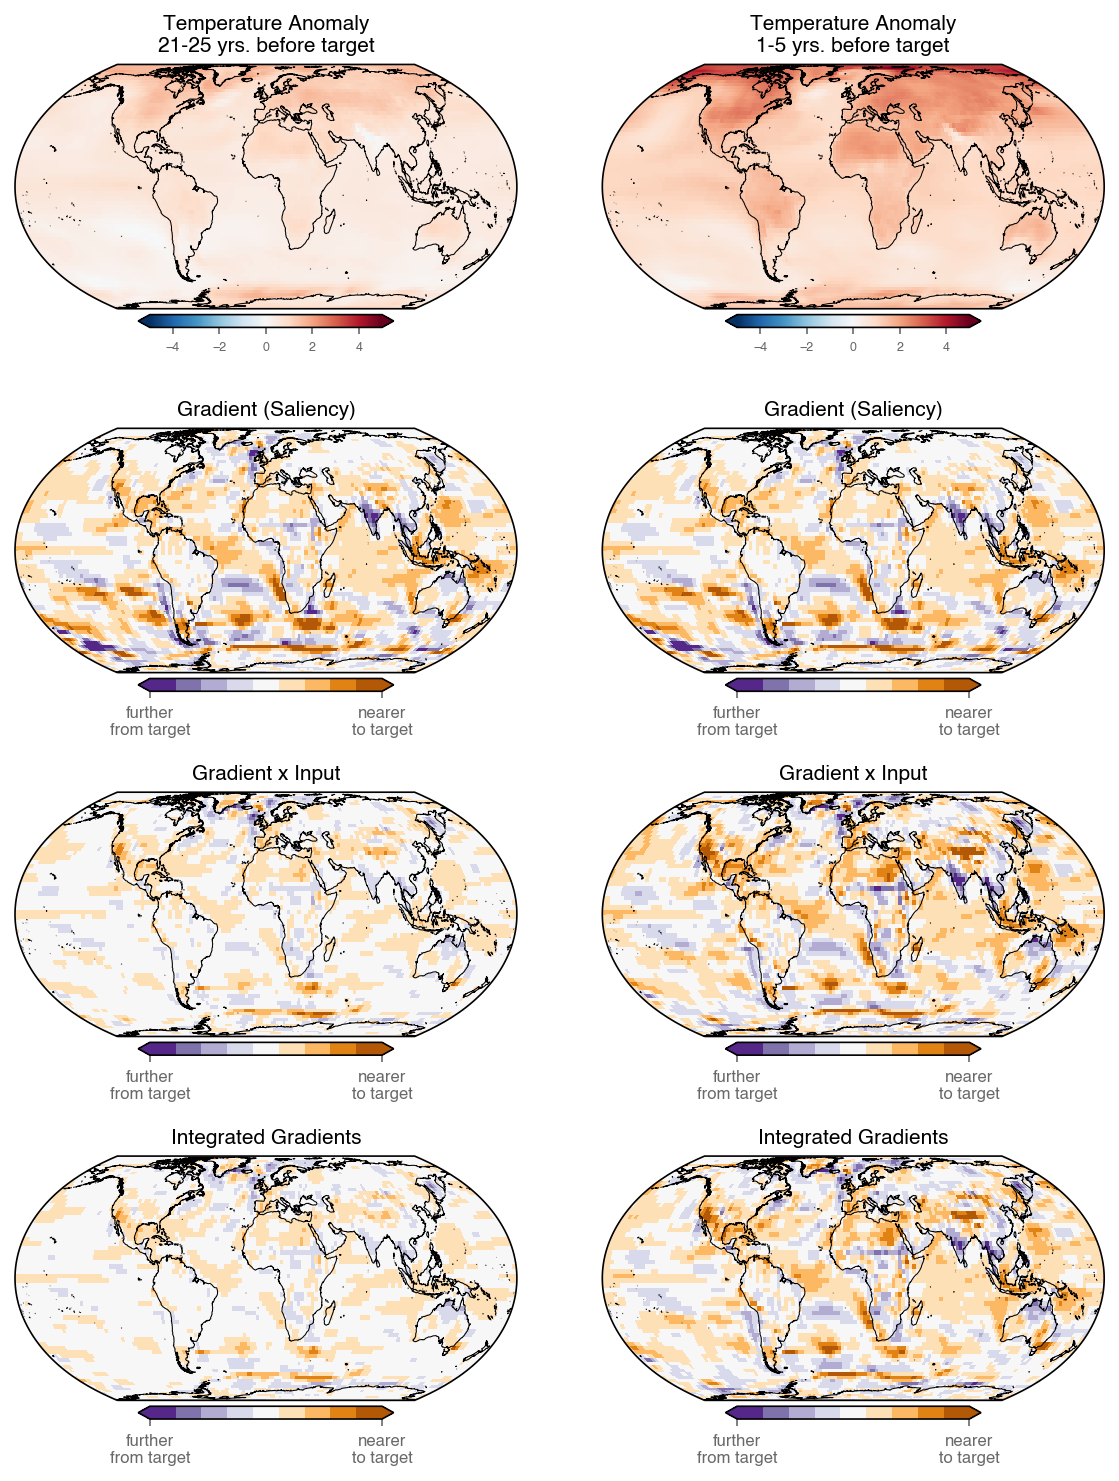

In [9]:
map_proj = ct.crs.EqualEarth(central_longitude = 0.)

# plot the resulting heatmaps for a subset of samples
# based on their label
plot_list = (21, 1)
NCOL = 4

fig = plt.figure(figsize=(4*len(plot_list),10))
# plt.subplots(len(plot_list),NCOL,figsize=(35,5*len(plot_list)))

for irow,min_range in enumerate(plot_list):
        
    max_range = min_range + 4
    isamples = np.where((targets >= min_range) & (targets <= max_range))[0]
    igrad_mean = np.mean(integrated_gradients[isamples,:,:],axis=0)
    grad_x_input_mean = np.mean(grad_x_input[isamples,:,:],axis=0)
    grad_mean = np.mean(grads[isamples,:],axis=0).reshape((map_shape[0],map_shape[1]))
    x_inputs_mean = np.mean(inputs[isamples,:],axis=0).reshape((map_shape[0],map_shape[1]))
    x_inputs_mean = x_inputs_mean - baseline_mean.reshape((map_shape[0],map_shape[1]))
    #------------------------------------------------------------------
    
    text = (
            "\n"
            + f"  label_range    = {min_range}-{max_range} yrs.\n"                    
            + f"  n_samples      = {len(isamples)}\n"
    )  
    print(text)
    #------------------------------------------------------------------    
    # plot average input map
    ax = fig.add_subplot(NCOL,len(plot_list),irow+1,projection=map_proj)
    cb,image = plots.drawOnGlobe(ax, 
                      map_proj, 
                      data=x_inputs_mean, # multiplying by negative 1 so colorbar has warm colors on the right 
                      lats=da_obs['lat'], 
                      lons=da_obs['lon'], 
                      cmap='RdBu_r',
                      vmin= -5, 
                      vmax= 5, 
                      inc=None, 
                      cbarBool=True, 
                      contourMap=[], 
                      contourVals = [], 
                      fastBool=True, 
                      extent='both',
                     )
    ax.set_title('Temperature Anomaly\n' + str(min_range) + '-' + str(max_range) + ' yrs. before target',fontsize=FS)
    
    #------------------------------------------------------------------
    # plot explainability of gradient (saliency)    
    ax = fig.add_subplot(NCOL,len(plot_list),3+irow,projection=map_proj)
    cb,image = plots.drawOnGlobe(ax, 
                      map_proj, 
                      data=grad_mean*-1, # multiplying by negative 1 so colorbar has warm colors on the right 
                      lats=da_obs['lat'], 
                      lons=da_obs['lon'], 
                      vmin= -0.05, 
                      vmax= 0.05, 
                      inc=None, 
                      cmap=ListedColormap(['#b35806','#e08214','#fdb863','#fee0b6','#f7f7f7','#d8daeb','#b2abd2','#8073ac','#542788'][::-1]),#cmocean.cm.tarn,
                      cbarBool=True, 
                      contourMap=[], 
                      contourVals = [], 
                      fastBool=True, 
                      extent='both',
                     )
    set_cb_xai(cb)    
    ax.set_title('Gradient (Saliency)',fontsize=FS)    
        
#     #------------------------------------------------------------------
#     # plot explainability of input x gradient
    ax = fig.add_subplot(NCOL,len(plot_list),5+irow,projection=map_proj)
    cb,image = plots.drawOnGlobe(ax, 
                      map_proj, 
                      data=grad_x_input_mean*-1, # multiplying by negative 1 so colorbar has warm colors on the right 
                      lats=da_obs['lat'], 
                      lons=da_obs['lon'], 
                      vmin= -0.05, 
                      vmax= 0.05, 
                      inc=None, 
                      cmap=ListedColormap(['#b35806','#e08214','#fdb863','#fee0b6','#f7f7f7','#d8daeb','#b2abd2','#8073ac','#542788'][::-1]),#cmocean.cm.tarn,
                      cbarBool=True, 
                      contourMap=[], 
                      contourVals = [], 
                      fastBool=True, 
                      extent='both',
                     )
    set_cb_xai(cb)    
    ax.set_title('Gradient x Input',fontsize=FS)    

#     #------------------------------------------------------------------
#     # plot explainability of integrated gradients
    ax = fig.add_subplot(NCOL,len(plot_list),7+irow,projection=map_proj)
    cb,image = plots.drawOnGlobe(ax, 
                      map_proj, 
                      data=igrad_mean*-1, # multiplying by negative 1 so colorbar has warm colors on the right 
                      lats=da_obs['lat'], 
                      lons=da_obs['lon'], 
                      vmin= -0.05, 
                      vmax= 0.05, 
                      inc=None, 
                      cmap=ListedColormap(['#b35806','#e08214','#fdb863','#fee0b6','#f7f7f7','#d8daeb','#b2abd2','#8073ac','#542788'][::-1]),#cmocean.cm.tarn,
                      cbarBool=True, 
                      contourMap=[], 
                      contourVals = [], 
                      fastBool=True, 
                      extent='both',
                     )
    set_cb_xai(cb)
    ax.set_title('Integrated Gradients',fontsize=FS) 
    
plt.tight_layout()   
plt.savefig(FIGURE_DIRECTORY + model_name + '_cmip_xaiGrid.png', 
            dpi=savefig_dpi,
            bbox_inches="tight",
           )
plt.show()



In [10]:
# # plot the resulting heatmaps for a subset of samples
# # based on their label
# plot_list = (40, 20, 10, 0)
# NCOL = 4

# plt.subplots(len(plot_list),NCOL,figsize=(35,5*len(plot_list)))

# for irow,min_range in enumerate(plot_list):
        
#     max_range = min_range + 5
#     isamples = np.where((targets >= min_range) & (targets <= max_range))[0]
#     igrad_mean = np.mean(integrated_gradients[isamples,:,:],axis=0)
#     grad_x_input_mean = np.mean(grad_x_input[isamples,:,:],axis=0)
#     grad_mean = np.mean(grads[isamples,:],axis=0).reshape((map_shape[0],map_shape[1]))
#     x_inputs_mean = np.mean(inputs[isamples,:],axis=0).reshape((map_shape[0],map_shape[1]))
#     x_inputs_mean = x_inputs_mean - baseline_mean.reshape((map_shape[0],map_shape[1]))
#     #------------------------------------------------------------------
    
#     text = (
#             "\n"
#             + f"  label_range    = {min_range}-{max_range} yrs.\n"                    
#             + f"  n_samples      = {len(isamples)}\n"
#     )    
#     #------------------------------------------------------------------    
    
#     # plot average input map
#     plt.subplot(len(plot_list),NCOL,irow*NCOL+1)
#     plots.plot_map(x_inputs_mean, 
#              text=text,
#              clim=(-5,5),
#              cmap='RdBu_r',
#              title = 'Temperature anomaly from Baseline',
#             )
#     #------------------------------------------------------------------
#     # plot explainability of gradient (saliency)
#     plt.subplot(len(plot_list),NCOL,irow*NCOL+2)
#     plots.plot_map(grad_mean, 
#              text=text,             
#              clim=(-0.02, .02), 
#              title = 'Gradient (Saliency)',
#             )
    
#     #------------------------------------------------------------------
#     # plot explainability of input x gradient
#     plt.subplot(len(plot_list),NCOL,irow*NCOL+3)
#     plots.plot_map(grad_x_input_mean, 
#              text=text,
#              clim=(-.02,.02),
#              title = 'Gradient x Input',
#             )

#     #------------------------------------------------------------------
#     # plot explainability of integrated gradients
#     plt.subplot(len(plot_list),NCOL,irow*NCOL+4)
#     plots.plot_map(igrad_mean, 
#              text=text,             
#              clim=(-.02,.02), 
#              title = 'Integrated Gradients',
#             )

# plt.tight_layout()   

# plt.savefig(FIGURE_DIRECTORY + model_name + '_cmip_xaiGrid.png', dpi=savefig_dpi)
# plt.show()



## XAI for Models and Obs

In [11]:
n_plot = 4
top_pred_idx=0

grads_obs = xai.get_gradients(model,x_obs[-n_plot:,:],top_pred_idx=top_pred_idx).numpy()*x_obs[-n_plot:,:]
print('np.shape(grads_obs) = ' + str(np.shape(grads_obs)))
grads_obs_mean = np.mean(grads_obs,axis=0)

np.shape(grads_obs) = (4, 10368)


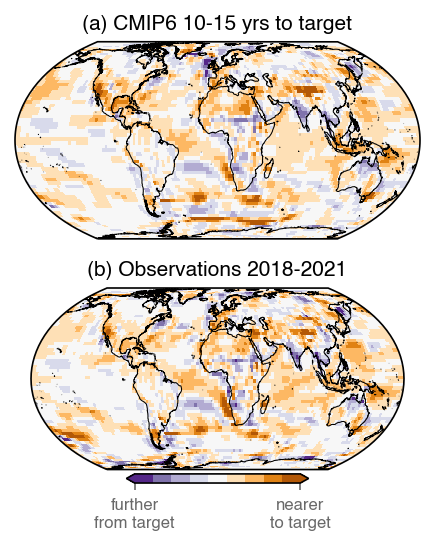

In [12]:
imp.reload(plots)
map_proj = ct.crs.EqualEarth(central_longitude = 0.)
fig = plt.figure(figsize=(3.,3.75))

for iloop,map_type in enumerate(('cmip','obs')):
    if(map_type=='cmip'):
        min_range = 10
        max_range = min_range + 5
        isamples = np.where((targets >= min_range) & (targets <= max_range))[0]
        igrad_mean = np.mean(integrated_gradients[isamples,:,:],axis=0)
        grad_x_input_mean = np.mean(grad_x_input[isamples,:,:],axis=0)        
        plot_grads = grad_x_input_mean.reshape((len(da_obs['lat']),len(da_obs['lon']))) 

        cbarBool = False
        title_text = '(a) CMIP6 ' + str(min_range) + '-' + str(max_range) + ' yrs to target'
        
    elif(map_type=='obs'):
        plot_grads = grads_obs_mean.reshape((len(da_obs['lat']),len(da_obs['lon'])))

        cbarBool = True
        title_text = '(b) Observations ' + str(2021-n_plot+1) + '-' + str(2021) 
        
    else:
        raise NotImplemented('no such map_type')
    
    ax = fig.add_subplot(2,1,iloop+1,projection=map_proj)
    cb,image = plots.drawOnGlobe(ax, 
                      map_proj, 
                      data=plot_grads*-1, # multiplying by negative 1 so colorbar has warm colors on the right 
                      lats=da_obs['lat'], 
                      lons=da_obs['lon'], 
                      cmap=ListedColormap(['#b35806','#e08214','#fdb863','#fee0b6','#f7f7f7','#d8daeb','#b2abd2','#8073ac','#542788'][::-1]),#cmocean.cm.tarn,
                      vmin= -0.04, 
                      vmax= 0.04, 
                      inc=None, 
                      cbarBool=cbarBool, 
                      contourMap=[], 
                      contourVals = [], 
                      fastBool=False, 
                      extent='both',
                     )
    ax.set_title(title_text, fontsize=FS*1.0)
    if cbarBool:
        cb.set_label(None)
        cb.ax.set_xticks((-0.04,0.04))
        cb.ax.set_xticklabels(['further\nfrom target','nearer\nto target'],
                              fontsize=FS*.8,
                             )
        
plt.tight_layout()

plt.savefig(FIGURE_DIRECTORY + model_name + '_cmip_obs_xai_grad_x_input.png', 
            dpi=savefig_dpi,
            bbox_inches="tight",
           )
plt.show()